# Simulation - Replication Cozzi and Galli

## Exogenous Skill Acquisition

The following code attempts to replicate simulations performed by Cozzi \& Galli (2014). 
Endogenous model has no numerical solutions and would require numeraical simulations of different steady states. I have proceeded with exogenous model to capture my understanding of the model.

Different versions of the draft are available online. I leverage the one with equations for the endogenous models. 

Initially, I intended to leverage fsolve to perform the numerical simulations. As the equations are nonlinear and become quite complicated and that parameters were not specified in the paper, I used a simplified method to assess the model.



In [9]:
#pip install numpy scipy
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore')

In [2]:
def create_beta_values(vmin, vmax): 
    '''
    this function takes in min and max to create an array of beta
    Consistent with the paper, beta would rise very quickly in a concave way from t=0 to t=50, at t=50, the value would stabilise at the new beta

    the simulation takes beta = [0.35, 0.50] and [0.50, 0.65] 
    '''
    y_min = vmin  # Starting value
    y_max = vmax  # Stable value
    num_samples = 500  # Number of samples
    
    # Step 1: Create an array of x values (0 to 1)
    x_values = np.linspace(0, 1, 500)
    
    # Step 2: Define a function that rises quickly at x=0 and then stabilizes
    def concave_function(x):
        # Using an exponential decay function for rapid initial rise
        return y_min + (y_max - y_min) * (1 - np.exp(-5 * x))
    
    # Step 3: Generate y values using the defined function
    y_values = concave_function(x_values)
    stable_values = np.repeat(vmax, 500)
    y_values = np.concatenate((y_values, stable_values))
    x_values = np.linspace(0, 1, 1000)

    return x_values, y_values 


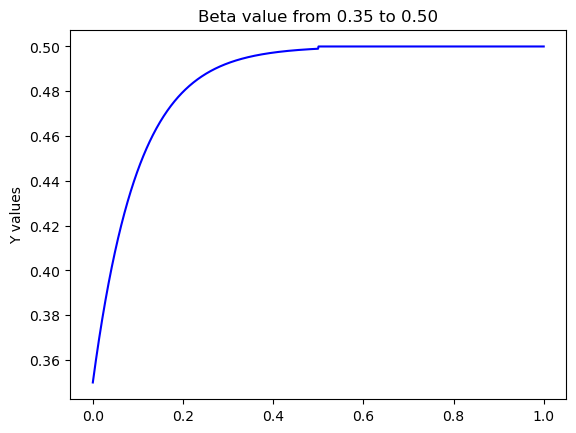

In [3]:
# Use function create_beta_values
plt.plot(create_beta_values(0.35, 0.50)[0], create_beta_values(0.35, 0.50)[1], label='Concave Function', color='blue')
plt.title('Beta value from 0.35 to 0.50')
plt.ylabel('Y values')
plt.show()


In [37]:
def estimates_df(beta_values, r=0.02):
    '''
    This function takes the list of beta and find the value of n_A, n_B, wage premium and vB.
    The equations for the SS are all at the same t. 
    Due to time restriction, I only took a handful variables. 
    This function returns a dataframe of the result
    '''
    
    initial_guess=0.1
    alpha=0.1
    h=0.4
    l=0.6
    nA_estimates = []
    nB_estimates = []
    m_estimates = []
    w_H_estimates = []
    vB_estimates = []
    
    # Define the equation to find beta assuming l and h following exogenous are 0.5 and 0.5
    def equation(n_A, beta):
        return (h - n_A)**alpha * (r / n_A + 1 / n_A**alpha) - beta/(1-beta)

    # For each look, find value for n_A and then find the other values
    for beta in beta_values:
        n_A = fsolve(equation, initial_guess, args=(beta))[0]
        n_B = h-n_A
        m = 1/(1+(n_B/n_A)**(1-alpha))
        x = h - m*n_B - (1-m)*n_A
        w_H = l*alpha/(x*(1-alpha))
        vB = w_H*n_B**alpha
        
        nA_estimates.append(n_A)
        nB_estimates.append(n_B)
        m_estimates.append(m)
        w_H_estimates.append(w_H)
        vB_estimates.append(vB)    
        
    time = np.linspace(0, 100, 1000)
    df_sim = pd.DataFrame({ # Not sure how paper balanced the result. It says that it is normalized against initial position. 
        'beta': beta_values-beta_values[0],
        'nA': nA_estimates/nA_estimates[0]-1,
        'time': time, 
        'nB': nB_estimates/nB_estimates[0]-1,
        'wage': w_H_estimates/w_H_estimates[0]-1,
        'vB': vB_estimates/vB_estimates[0] -1
        })

    return df_sim

In [38]:
def graph(data):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    sns.scatterplot(x='time', y='nA', data=data, ax=axes[0, 1])
    axes[0, 1].set_title('number of applied researcher workers')
    
    sns.scatterplot(x='time', y='nB',data=data, ax=axes[1, 0])
    axes[1, 0].set_title('number of basic workers')

    sns.scatterplot(x='time', y='wage',data=data, ax=axes[1, 1])
    axes[1, 1].set_title('wage')

    sns.scatterplot(x='time', y='vB',data=data, ax=axes[0, 0])
    axes[0, 0].set_title('value of Basic research')

## Start with beta from 0.35 to 0.50

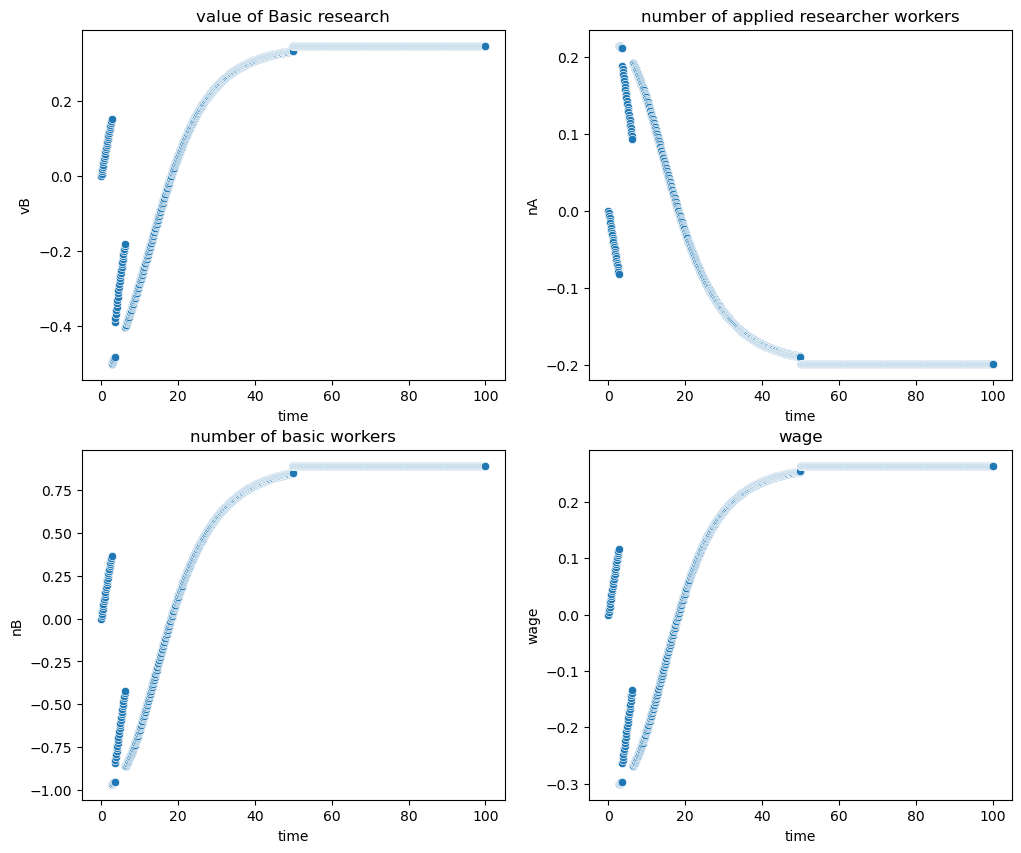

In [39]:
graph(estimates_df(create_beta_values(0.35, 0.50)[1]))

## Then with beta from 0.55 to 0.65

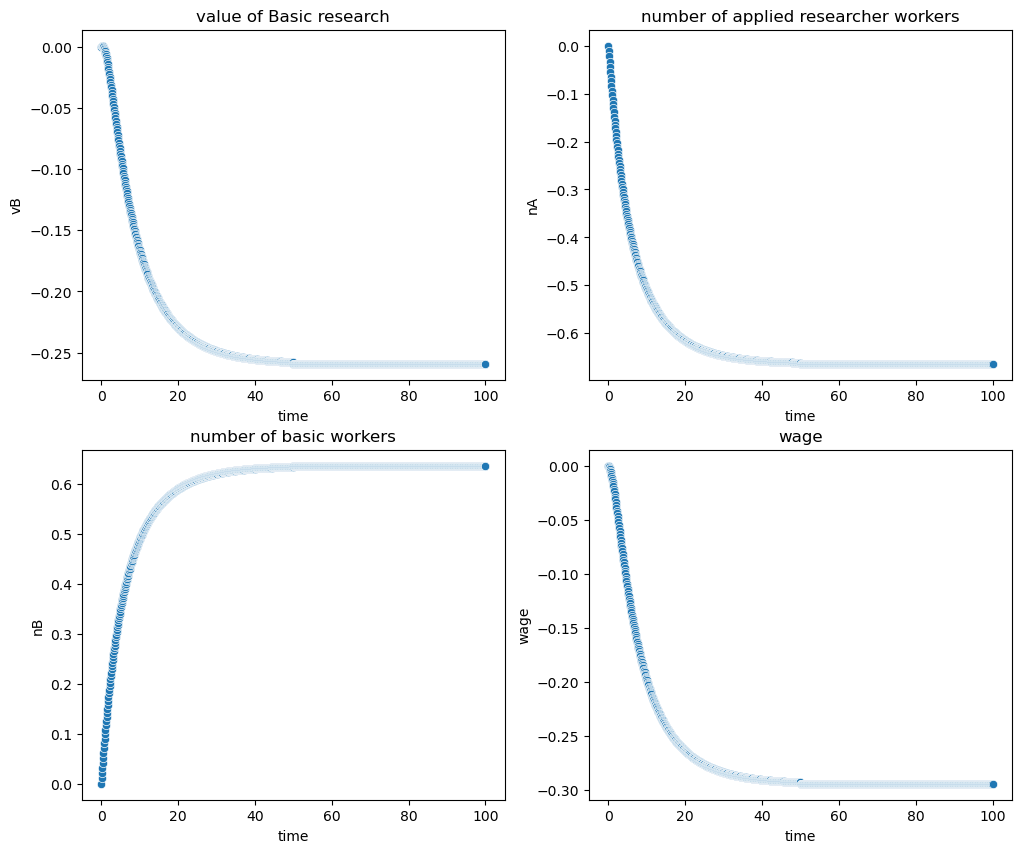

In [40]:
graph(estimates_df(create_beta_values(0.55, 0.65)[1], 0.05))